# Pylops - Marchenko on GPU with cupy

In [1]:
# install conda (https://towardsdatascience.com/conda-google-colab-75f7c867a522)
%env PYTHONPATH=

env: PYTHONPATH=


In [2]:
%%bash
MINICONDA_INSTALLER_SCRIPT=Miniconda3-4.5.4-Linux-x86_64.sh
MINICONDA_PREFIX=/usr/local
wget https://repo.continuum.io/miniconda/$MINICONDA_INSTALLER_SCRIPT
chmod +x $MINICONDA_INSTALLER_SCRIPT
./$MINICONDA_INSTALLER_SCRIPT -b -f -p $MINICONDA_PREFIX

PREFIX=/usr/local
installing: python-3.6.5-hc3d631a_2 ...
installing: ca-certificates-2018.03.07-0 ...
installing: conda-env-2.6.0-h36134e3_1 ...
installing: libgcc-ng-7.2.0-hdf63c60_3 ...
installing: libstdcxx-ng-7.2.0-hdf63c60_3 ...
installing: libffi-3.2.1-hd88cf55_4 ...
installing: ncurses-6.1-hf484d3e_0 ...
installing: openssl-1.0.2o-h20670df_0 ...
installing: tk-8.6.7-hc745277_3 ...
installing: xz-5.2.4-h14c3975_4 ...
installing: yaml-0.1.7-had09818_2 ...
installing: zlib-1.2.11-ha838bed_2 ...
installing: libedit-3.1.20170329-h6b74fdf_2 ...
installing: readline-7.0-ha6073c6_4 ...
installing: sqlite-3.23.1-he433501_0 ...
installing: asn1crypto-0.24.0-py36_0 ...
installing: certifi-2018.4.16-py36_0 ...
installing: chardet-3.0.4-py36h0f667ec_1 ...
installing: idna-2.6-py36h82fb2a8_1 ...
installing: pycosat-0.6.3-py36h0a5515d_0 ...
installing: pycparser-2.18-py36hf9f622e_1 ...
installing: pysocks-1.6.8-py36_0 ...
installing: ruamel_yaml-0.15.37-py36h14c3975_2 ...
installing: six-1.11

--2020-09-30 20:08:52--  https://repo.continuum.io/miniconda/Miniconda3-4.5.4-Linux-x86_64.sh
Resolving repo.continuum.io (repo.continuum.io)... 104.18.201.79, 104.18.200.79, 2606:4700::6812:c94f, ...
Connecting to repo.continuum.io (repo.continuum.io)|104.18.201.79|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://repo.anaconda.com/miniconda/Miniconda3-4.5.4-Linux-x86_64.sh [following]
--2020-09-30 20:08:52--  https://repo.anaconda.com/miniconda/Miniconda3-4.5.4-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.131.3, 104.16.130.3, 2606:4700::6810:8303, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.131.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 58468498 (56M) [application/x-sh]
Saving to: ‘Miniconda3-4.5.4-Linux-x86_64.sh’

     0K .......... .......... .......... .......... ..........  0% 75.2M 1s
    50K .......... .......... .......... .......... ..........  0%

In [3]:
%%bash
conda install --channel defaults conda python=3.6 --yes
conda update --channel defaults --all --yes

Solving environment: ...working... done

## Package Plan ##

  environment location: /usr/local

  added / updated specs: 
    - conda
    - python=3.6


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    urllib3-1.25.10            |             py_0          93 KB
    libstdcxx-ng-9.1.0         |       hdf63c60_0         4.0 MB
    ca-certificates-2020.7.22  |                0         132 KB
    openssl-1.1.1h             |       h7b6447c_0         3.8 MB
    pycosat-0.6.3              |   py36h7b6447c_0         107 KB
    conda-4.8.5                |           py36_0         3.0 MB
    python-3.6.12              |       hcff3b4d_2        34.0 MB
    pycparser-2.20             |             py_2          94 KB
    six-1.15.0                 |             py_0          13 KB
    conda-package-handling-1.6.1|   py36h7b6447c_0         886 KB
    chardet-3.0.4              |        py36_1003  

urllib3-1.25.10      |   93 KB | ########## | 100% 
libstdcxx-ng-9.1.0   |  4.0 MB | ########## | 100% 
ca-certificates-2020 |  132 KB | ########## | 100% 
openssl-1.1.1h       |  3.8 MB | ########## | 100% 
pycosat-0.6.3        |  107 KB | ########## | 100% 
conda-4.8.5          |  3.0 MB | ########## | 100% 
python-3.6.12        | 34.0 MB | ########## | 100% 
pycparser-2.20       |   94 KB | ########## | 100% 
six-1.15.0           |   13 KB | ########## | 100% 
conda-package-handli |  886 KB | ########## | 100% 
chardet-3.0.4        |  197 KB | ########## | 100% 
pip-20.2.2           |  2.0 MB | ########## | 100% 
requests-2.24.0      |   54 KB | ########## | 100% 
idna-2.10            |   56 KB | ########## | 100% 
cryptography-3.1.1   |  612 KB | ########## | 100% 
pysocks-1.7.1        |   30 KB | ########## | 100% 
tk-8.6.10            |  3.2 MB | ########## | 100% 
tqdm-4.49.0          |   54 KB | ########## | 100% 
readline-8.0         |  428 KB | ########## | 100% 
libedit-3.1.

In [4]:
!python --version # now returns Python 3.6.10 :: Anaconda, Inc.

Python 3.6.12 :: Anaconda, Inc.


In [5]:
import sys
_ = (sys.path.append("/usr/local/lib/python3.6/site-packages"))

In [6]:
!conda install -c rapidsai -c conda-forge cusignal cudatoolkit=10.1 --yes

Solving environment: | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - cudatoolkit=10.1
    - cusignal


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    boost-1.74.0               |   py36h6957fcd_0         316 KB  conda-forge
    boost-cpp-1.74.0           |       h9359b55_0        16.4 MB  conda-forge
    bzip2-1.0.8                |       h516909a_3         398 KB  conda-forge
    ca-certificates-2020.6.20  |       hecda079_0         145 KB  conda-forge
    certifi-2020.6.20          |   py36h9f0ad1d_0         151 KB  conda-forge
    conda-4.8.5                |   py36h9f0ad1d_1         3.0 MB  conda-forge
    cudatoolkit-10.1.243       |       h6bb024c_0       347.4 MB
    cudnn-7.6.5                |       cuda10.1_0       179.9 MB
    cupy-7.8.0

In [7]:
#!pip install cupy-cuda101
!pip3 install cupy-cuda101==8.0.0rc1 --upgrade
#!pip install pylops[advanced]
!pip3 install git+https://github.com/mrava87/pylops@cupy-ext

     |████████████████████████████████| 114.9 MB 6.7 kB/s 
  Cloning https://github.com/mrava87/pylops (to revision cupy-ext) to /tmp/pip-req-build-nz2ylp0y
  Created wheel for pylops: filename=pylops-1.10.1.dev54+g90239e7-py3-none-any.whl size=155514 sha256=48a3e207ef03b1df33fe9215522b52dcbfb21a990e84083ce7a07665dadf3f48
  Stored in directory: /tmp/pip-ephem-wheel-cache-y0lpq3wm/wheels/92/3f/33/bb1bd7335dab4f72f8e54c5c935b290d143c80c09cb50b8b28
Successfully built pylops


In [8]:
# all RAPIDS env... : https://medium.com/dropout-analytics/installing-rapids-ai-in-google-colab-87c247f2c468
# https://colab.research.google.com/drive/1rY7Ln6rEE1pOlfSHCYOVaqt8OvDO35J0#forceEdit=true&sandboxMode=true&scrollTo=CtNdk7PSafKP

In [9]:
!rm -rf /usr/local/lib/python3.6/dist-packages/cupy*

In [10]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import numpy as np
import cupy as cp
import scipy as sp
import cusignal
import matplotlib.pyplot as plt

from google.colab import drive
from scipy.signal import convolve, filtfilt
from scipy.sparse.linalg import inv, lsqr
from scipy.sparse import rand

from pylops.utils import dottest
from pylops.utils.wavelets import *
from pylops.utils.tapers import *
from pylops import LinearOperator
from pylops.basicoperators import *
from pylops.signalprocessing import *
from pylops.waveeqprocessing.marchenko import *
from pylops.optimization.solver import cgls

In [11]:
drive.mount('/content/gdrive')

inputfile = '/content/gdrive/My Drive/marchenko2d_input.npz'

Mounted at /content/gdrive


In [12]:
vel = 2400.0        # velocity
toff = 0.045        # direct arrival time shift
nsmooth = 10        # time window smoothing 
nfmax = 500         # max frequency for MDC (#samples)
nstaper = 11        # source/receiver taper lenght
n_iter = 10         # iterations

jr = 1              # subsampling in r
js = 1              # subsampling in s

inputdata = np.load(inputfile)

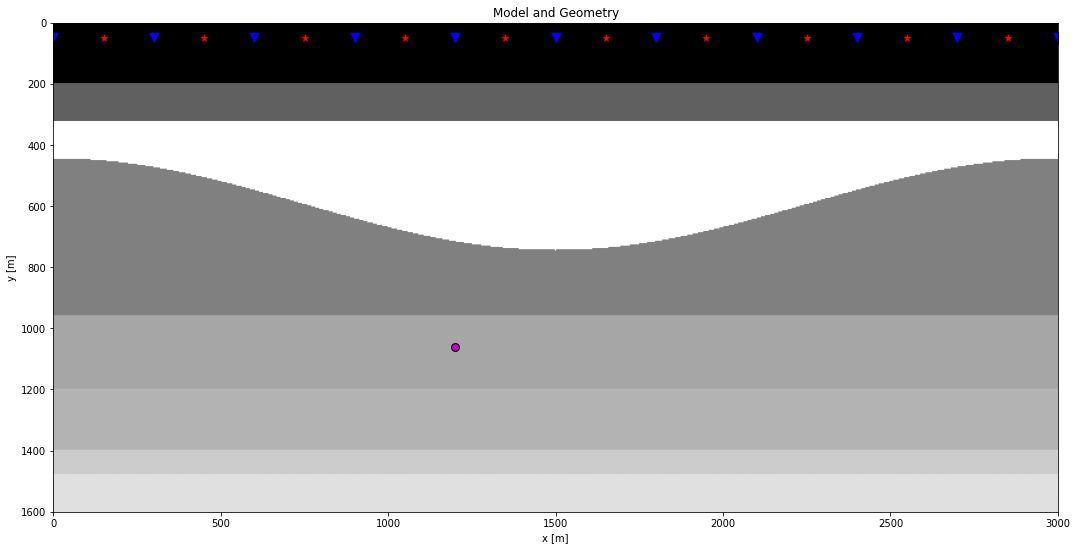

In [13]:
# Receivers
r = inputdata['r'][:,::jr]
nr = r.shape[1]
dr = r[0,1]-r[0,0]

# Sources
s = inputdata['s'][:,::js]
ns = s.shape[1]
ds = s[0,1]-s[0,0]

# Virtual points
vs = inputdata['vs']

# Density model
rho = inputdata['rho']
z, x = inputdata['z'], inputdata['x']

plt.figure(figsize=(18,9))
plt.imshow(rho, cmap='gray', extent = (x[0], x[-1], z[-1], z[0]))
plt.scatter(s[0, 5::10], s[1, 5::10], marker='*', s=150, c='r', edgecolors='k')
plt.scatter(r[0, ::10],  r[1, ::10], marker='v', s=150, c='b', edgecolors='k')
plt.scatter(vs[0], vs[1], marker='.', s=250, c='m', edgecolors='k')
plt.axis('tight')
plt.xlabel('x [m]'),plt.ylabel('y [m]'),plt.title('Model and Geometry')
plt.xlim(x[0], x[-1]);

In [14]:
# time axis
t = inputdata['t']
ot, dt, nt = t[0], t[1]-t[0], len(t)

# data
R = inputdata['R'][::js, ::jr]
R = np.swapaxes(R, 0, 1) # R[r, s, f] (for data with dipole source, you need to integrate over sources)

# tapering
taper = taper3d(nt, [ns, nr], [nstaper, nstaper], tapertype='hanning')
R = R*taper

In [15]:
Gsub = inputdata['Gsub'][:, ::jr]
G0sub = inputdata['G0sub'][:, ::jr]
wav = inputdata['wav']
wav_c = np.argmax(wav)

# convolve with wavelet
Gsub = np.apply_along_axis(convolve, 0, Gsub, wav, mode='full')
Gsub = Gsub[wav_c:][:nt]
G0sub = np.apply_along_axis(convolve, 0, G0sub, wav, mode='full') 
G0sub = G0sub[wav_c:][:nt]

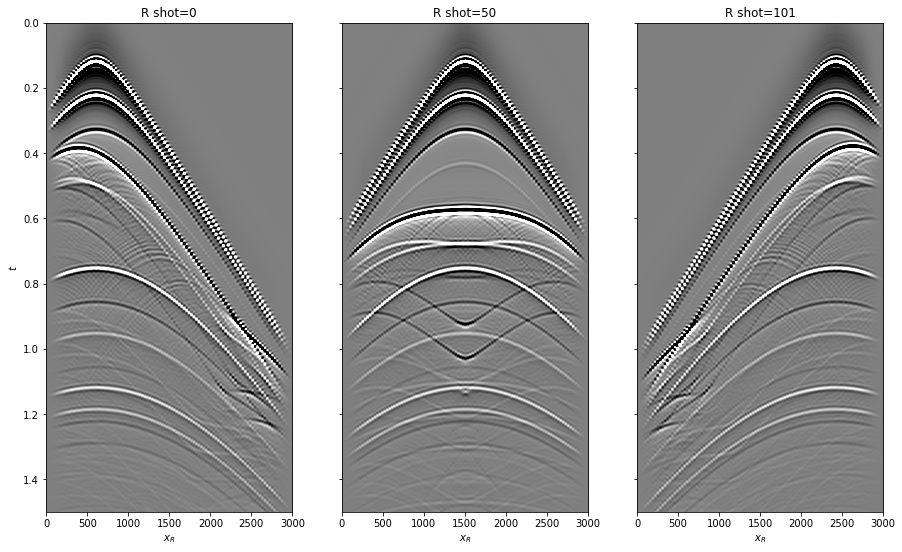

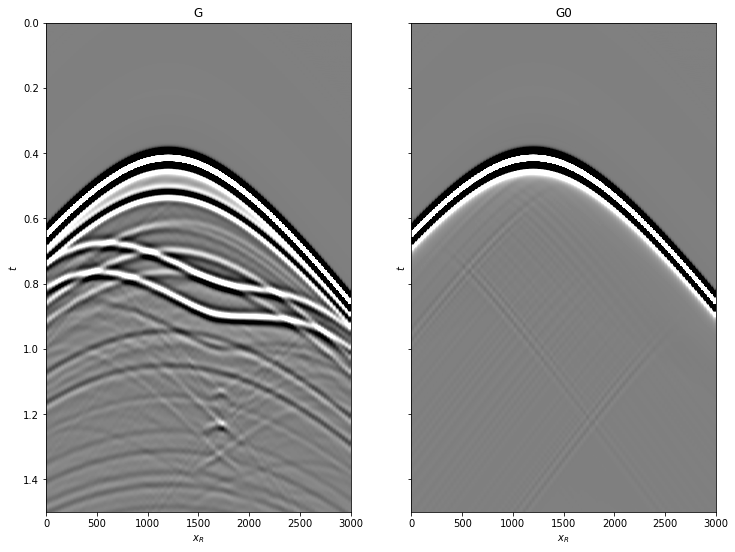

In [16]:
fig, axs = plt.subplots(1, 3, sharey=True, figsize=(15, 9))
axs[0].imshow(R[20].T, cmap='gray', vmin=-1e-2, vmax=1e-2, extent=(r[0,0], r[0,-1], t[-1], t[0]))
axs[0].set_title('R shot=0'), axs[0].set_xlabel(r'$x_R$'), axs[0].set_ylabel(r'$t$')
axs[0].axis('tight')
axs[0].set_ylim(1.5, 0)
axs[1].imshow(R[ns//2].T, cmap='gray', vmin=-1e-2, vmax=1e-2, extent=(r[0,0], r[0,-1], t[-1], t[0]))
axs[1].set_title('R shot=%d' %(ns//2)), axs[1].set_xlabel(r'$x_R$')
axs[1].axis('tight')
axs[1].set_ylim(1.5, 0)
axs[2].imshow(R[-20].T, cmap='gray', vmin=-1e-2, vmax=1e-2, extent=(r[0,0], r[0,-1], t[-1], t[0]))
axs[2].set_title('R shot=%d' %ns), axs[2].set_xlabel(r'$x_R$')
axs[2].axis('tight');
axs[2].set_ylim(1.5, 0)

fig, axs = plt.subplots(1, 2, sharey=True, figsize=(12, 9))
axs[0].imshow(Gsub, cmap='gray', vmin=-1e5, vmax=1e5, extent=(r[0,0], r[0,-1], t[-1], t[0]))
axs[0].set_title('G'), axs[0].set_xlabel(r'$x_R$'), axs[0].set_ylabel(r'$t$')
axs[0].axis('tight')
axs[0].set_ylim(1.5, 0)
axs[1].imshow(G0sub, cmap='gray', vmin=-1e5, vmax=1e5, extent=(r[0,0], r[0,-1], t[-1], t[0]))
axs[1].set_title('G0'), axs[1].set_xlabel(r'$x_R$'), axs[1].set_ylabel(r'$t$')
axs[1].axis('tight')
axs[1].set_ylim(1.5, 0);

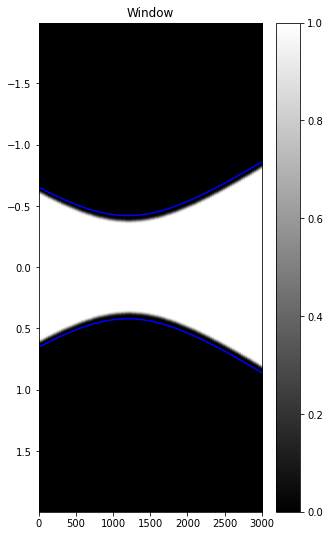

In [17]:
# direct arrival window - traveltime
directVS = np.sqrt((vs[0]-r[0])**2+(vs[1]-r[1])**2)/vel
directVS_off = directVS - toff

# window
idirectVS_off = np.round(directVS_off/dt).astype(np.int)
w = np.zeros((nr, nt))
for ir in range(nr):
    w[ir, :idirectVS_off[ir]]=1            
w = np.hstack((np.fliplr(w), w[:, 1:]))

if nsmooth>0:
    smooth=np.ones(nsmooth)/nsmooth
    w  = filtfilt(smooth, 1, w)    
    
fig, ax = plt.subplots(1, 1,  sharey=True, figsize=(5, 9))
im = ax.imshow(w.T, cmap='gray', extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
ax.plot(r[0], directVS,'b'),ax.plot(r[0], -directVS,'b')
ax.set_title('Window'), axs[0].set_xlabel(r'$x_R$'), axs[0].set_ylabel(r'$t$')
ax.axis('tight')
fig.colorbar(im, ax=ax);

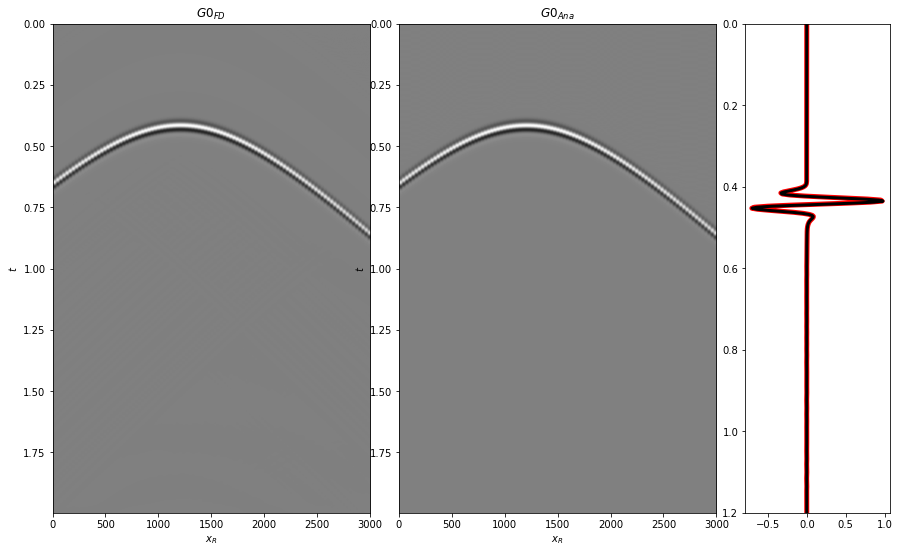

In [18]:
G0sub_ana = directwave(wav, directVS, nt, dt, nfft=2**11)

fig = plt.figure(figsize=(15,9))
ax1 = plt.subplot2grid((1, 5), (0, 0), colspan=2)
ax2 = plt.subplot2grid((1, 5), (0, 2), colspan=2)
ax3 = plt.subplot2grid((1, 5), (0, 4))

ax1.imshow(G0sub/G0sub.max(), cmap='gray', vmin=-1, vmax=1, 
           extent=(r[0,0], r[0,-1], t[-1], t[0]))
ax1.set_title(r'$G0_{FD}$'), ax1.set_xlabel(r'$x_R$'), ax1.set_ylabel(r'$t$')
ax1.axis('tight')
ax2.imshow(G0sub_ana/G0sub_ana.max(), cmap='gray', vmin=-1, vmax=1, 
           extent=(r[0,0], r[0,-1], t[-1], t[0]))
ax2.set_title(r'$G0_{Ana}$'), ax2.set_xlabel(r'$x_R$'), ax2.set_ylabel(r'$t$')
ax2.axis('tight')

ax3.plot(G0sub[:, nr//2]/G0sub.max(), t, 'r', lw=5)
ax3.plot(G0sub_ana[:, nr//2]/G0sub_ana.max(), t, 'k', lw=3)
ax3.set_ylim(1.2, 0);

## Numpy

In [19]:
# Add negative time to operators
Rtwosided = np.concatenate((np.zeros((nr, ns, nt-1)), R), axis=-1)
Rtwosided_fft = np.fft.rfft(Rtwosided, 2*nt-1, axis=-1)/np.sqrt(2*nt-1)
Rtwosided_fft = Rtwosided_fft[...,:nfmax]
Rtwosided_fft = Rtwosided_fft.transpose(2, 0, 1) # R[f, r, s]

# Operators
Rop = MDC(Rtwosided_fft, nt=2*nt-1, nv=1, dt=dt, dr=ds, twosided=True, transpose=False)
R1op = MDC(Rtwosided_fft, nt=2*nt-1, nv=1, dt=dt, dr=ds, twosided=True, transpose=False, conj=True)
Rollop = Roll((2*nt-1) * nr,
              dims=(2*nt-1, nr),
              dir=0, shift=-1)

# Input focusing function
fd_plus =  np.concatenate((np.fliplr(G0sub.T).T, np.zeros((nt-1, nr), dtype='float32')))

Wop = Diagonal(w.T.flatten(), dtype='float32')
Iop = Identity(nr*(2*nt-1), dtype='float32')

Mop = VStack([HStack([Iop, -1*Wop*Rop]),
              HStack([-1*Wop*Rollop*R1op, Iop])])*BlockDiag([Wop, Wop])
Gop = VStack([HStack([Iop, -1*Rop]),
              HStack([-1*Rollop*R1op, Iop])])

p0_minus = Rop * fd_plus.flatten()
p0_minus = p0_minus.reshape((2*nt-1), nr).T

d = Wop*Rop*fd_plus.flatten()
d = np.concatenate((d.reshape(2*nt-1, nr), np.zeros((2*nt-1, nr), dtype='float32')))

f1_adj = Mop.H*d.flatten()
f1_inv = cgls(Mop, d.flatten(), x0=np.zeros(2*(2*nt-1)*nr, dtype='float32'), niter=n_iter, show=True)[0]

f1_adj = f1_adj.reshape(2*(2*nt-1), nr)
f1_inv = f1_inv.reshape(2*(2*nt-1), nr)

/usr/local/lib/python3.6/site-packages/pylops/waveeqprocessing/mdd.py:38: FutureWarning: A new implementation of MDC is provided in v1.5.0. This currently affects only the inner working of the operator, end-users can continue using the operator in the same way. Nevertheless, it is now recommended to start using the operator with transpose=True, as this behaviour will become default in version v2.0.0 and the behaviour with transpose=False will be deprecated.
  'transpose=False will be deprecated.', FutureWarning)


CGLS
-----------------------------------------------------------
The Operator Op has 322998 rows and 322998 cols
damp = 0.000000e+00	tol = 1.000000e-04	niter = 10
-----------------------------------------------------------------
    Itn           x[0]              r2norm
     1         0.0000e+00         1.9349e+14
     2         0.0000e+00         2.7132e+13
     3         0.0000e+00         1.5077e+13
     4         0.0000e+00         8.7539e+12
     5         0.0000e+00         4.3841e+12
     6         0.0000e+00         2.8600e+12
     7         0.0000e+00         1.7327e+12
     8         0.0000e+00         6.7220e+11
     9         0.0000e+00         3.4313e+11
    10         0.0000e+00         2.5729e+11

Iterations = 10        Total time (s) = 4.04
-----------------------------------------------------------------



## Cupy

In [20]:
# Convert to cupy
G0sub = cp.array(G0sub.astype(np.float32))
G0sub_ana = cp.array(G0sub_ana.astype(np.float32))
R = cp.array(R.astype(np.float32))
w = cp.array(w.astype(np.float32))

In [21]:
# Add negative time to operators
Rtwosided = cp.concatenate((cp.zeros((nr, ns, nt-1)), R), axis=-1)
Rtwosided_fft = np.fft.rfft(Rtwosided, 2*nt-1, axis=-1)/np.sqrt(2*nt-1)
Rtwosided_fft = Rtwosided_fft[...,:nfmax]
Rtwosided_fft = Rtwosided_fft.transpose(2, 0, 1) # R[f, r, s]

# Operators
Rop = MDC(Rtwosided_fft, nt=2*nt-1, nv=1, dt=dt, dr=ds, twosided=True, transpose=False)
R1op = MDC(Rtwosided_fft, nt=2*nt-1, nv=1, dt=dt, dr=ds, twosided=True, transpose=False, conj=True)
Rollop = Roll((2*nt-1) * nr,
              dims=(2*nt-1, nr),
              dir=0, shift=-1)

# Input focusing function
fd_plus =  cp.concatenate((cp.fliplr(G0sub.T).T, cp.zeros((nt-1, nr), dtype='float32')))
fd_plus.dtype

/usr/local/lib/python3.6/site-packages/pylops/waveeqprocessing/mdd.py:38: FutureWarning: A new implementation of MDC is provided in v1.5.0. This currently affects only the inner working of the operator, end-users can continue using the operator in the same way. Nevertheless, it is now recommended to start using the operator with transpose=True, as this behaviour will become default in version v2.0.0 and the behaviour with transpose=False will be deprecated.
  'transpose=False will be deprecated.', FutureWarning)


dtype('float32')

In [22]:
Wop = Diagonal(w.T.flatten(), dtype='float32')
Iop = Identity(nr*(2*nt-1), dtype='float32')

Mop = VStack([HStack([Iop, -1*Wop*Rop], dtype='float32'),
              HStack([-1*Wop*Rollop*R1op, Iop], dtype='float32')])*BlockDiag([Wop, Wop])
Gop = VStack([HStack([Iop, -1*Rop], dtype='float32'),
              HStack([-1*Rollop*R1op, Iop], dtype='float32')])

dottest(Gop, 2*nr*(2*nt-1), 2*nr*(2*nt-1), verb=True, backend='cupy')
dottest(Mop, 2*nr*(2*nt-1), 2*nr*(2*nt-1), verb=True, backend='cupy');

Dot test passed, v^T(Opu)=224.660082 - u^T(Op^Tv)=224.660058
Dot test passed, v^T(Opu)=182.048794 - u^T(Op^Tv)=182.048809


In [23]:
p0_minus = Rop * fd_plus.flatten()
p0_minus = p0_minus.reshape((2*nt-1), nr).T

In [24]:
d = Wop*Rop*fd_plus.flatten()
d = cp.concatenate((d.reshape(2*nt-1, nr), cp.zeros((2*nt-1, nr), dtype='float32')))

f1_adj = Mop.H*d.flatten()
f1_inv = cgls(Mop, d.flatten(), x0=cp.zeros(2*(2*nt-1)*nr, dtype='float32'), niter=n_iter, show=True)[0]

f1_adj = f1_adj.reshape(2*(2*nt-1), nr)
f1_inv = f1_inv.reshape(2*(2*nt-1), nr)

CGLS
-----------------------------------------------------------
The Operator Op has 322998 rows and 322998 cols
damp = 0.000000e+00	tol = 1.000000e-04	niter = 10
-----------------------------------------------------------------
    Itn           x[0]              r2norm
     1         0.0000e+00         1.9349e+14
     2         0.0000e+00         2.7133e+13
     3         0.0000e+00         1.5077e+13
     4         0.0000e+00         8.7541e+12
     5         0.0000e+00         4.3842e+12
     6         0.0000e+00         2.8601e+12
     7         0.0000e+00         1.7327e+12
     8         0.0000e+00         6.7221e+11
     9         0.0000e+00         3.4314e+11
    10         0.0000e+00         2.5729e+11

Iterations = 10        Total time (s) = 2.99
-----------------------------------------------------------------



In [25]:
f1_adj_tot = f1_adj + cp.concatenate((cp.zeros((2*nt-1, nr), dtype='float32'),
                                      cp.concatenate((cp.fliplr(G0sub.T).T, 
                                                      cp.zeros((nt-1, nr), dtype='float32')), axis=0)))

f1_inv_tot = f1_inv + cp.concatenate((cp.zeros((2*nt-1, nr), dtype='float32'),
                                      fd_plus))

In [26]:
g_adj = Gop*f1_adj_tot.flatten()
g_inv = Gop*f1_inv_tot.flatten()

g_adj = g_adj.reshape(2*(2*nt-1), nr)
g_inv = g_inv.reshape(2*(2*nt-1), nr)

In [27]:
f1_adj_minus, f1_adj_plus =  f1_adj_tot[:(2*nt-1)].T, f1_adj_tot[(2*nt-1):].T
f1_inv_minus, f1_inv_plus =  f1_inv_tot[:(2*nt-1)].T, f1_inv_tot[(2*nt-1):].T

g_adj_minus, g_adj_plus =  -g_adj[:(2*nt-1)].T, np.fliplr(g_adj[(2*nt-1):].T)
g_inv_minus, g_inv_plus =  -g_inv[:(2*nt-1)].T, np.fliplr(g_inv[(2*nt-1):].T)

g_inv_tot = g_inv_minus + g_inv_plus

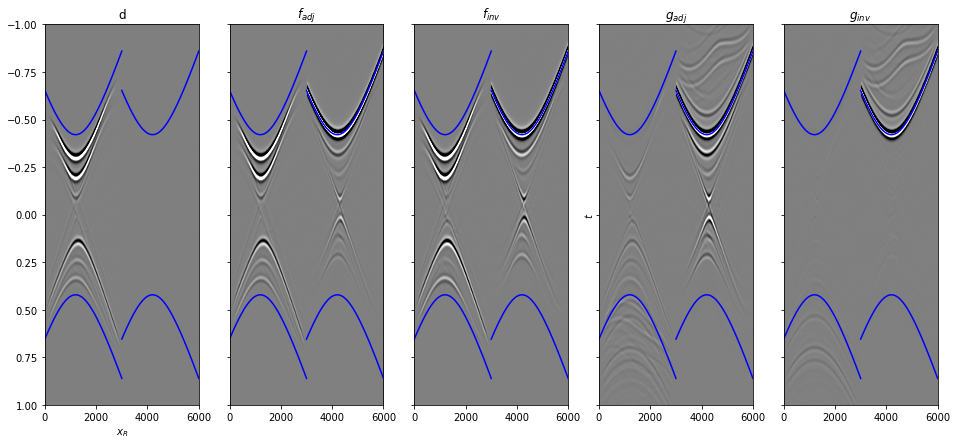

In [28]:
# Need to recreate combined data as new implementation stacks over time instead of space
d = cp.asnumpy(np.concatenate((d[:(2*nt-1)], d[(2*nt-1):]), axis=1).T)
f1_adj_tot = cp.asnumpy(np.concatenate((f1_adj_tot[:(2*nt-1)], f1_adj_tot[(2*nt-1):]), axis=1).T)
f1_inv_tot = cp.asnumpy(np.concatenate((f1_inv_tot[:(2*nt-1)], f1_inv_tot[(2*nt-1):]), axis=1).T)
g_adj = cp.asnumpy(np.concatenate((g_adj[:(2*nt-1)], g_adj[(2*nt-1):]), axis=1).T)
g_inv = cp.asnumpy(np.concatenate((g_inv[:(2*nt-1)], g_inv[(2*nt-1):]), axis=1).T)

fig, axs = plt.subplots(1, 5, sharey=True, figsize=(16, 7))
axs[0].imshow(d.T, cmap='gray', vmin=-5e5, vmax=5e5, extent=(r[0,0], 2*r[0,-1], t[-1], -t[-1]))
axs[0].set_title('d'), axs[0].set_xlabel(r'$x_R$'), axs[3].set_ylabel(r'$t$')
axs[0].plot(r[0], directVS,'b'),axs[0].plot(r[0], -directVS,'b')
axs[0].plot(r[0]+r[0,-1], directVS,'b'),axs[0].plot(r[0]+r[0,-1], -directVS,'b')
axs[0].axis('tight')
axs[0].set_ylim(1, -1)
axs[1].imshow(f1_adj_tot.T, cmap='gray', vmin=-5e5, vmax=5e5, extent=(r[0,0], 2*r[0,-1], t[-1], -t[-1]))
axs[1].set_title(r'$f_{adj}$'), axs[0].set_xlabel(r'$x_R$')
axs[1].plot(r[0], directVS,'b'),axs[1].plot(r[0], -directVS,'b')
axs[1].plot(r[0]+r[0,-1], directVS,'b'),axs[1].plot(r[0]+r[0,-1], -directVS,'b')
axs[1].axis('tight')
axs[1].set_ylim(1, -1);
axs[2].imshow(f1_inv_tot.T, cmap='gray', vmin=-5e5, vmax=5e5, extent=(r[0,0], 2*r[0,-1], t[-1], -t[-1]))
axs[2].set_title(r'$f_{inv}$'), axs[0].set_xlabel(r'$x_R$')
axs[2].plot(r[0], directVS,'b'),axs[2].plot(r[0], -directVS,'b')
axs[2].plot(r[0]+r[0,-1], directVS,'b'),axs[2].plot(r[0]+r[0,-1], -directVS,'b')
axs[2].axis('tight')
axs[2].set_ylim(1, -1);
axs[3].imshow(g_adj.T, cmap='gray', vmin=-5e5, vmax=5e5, extent=(r[0,0], 2*r[0,-1], t[-1], -t[-1]))
axs[3].set_title(r'$g_{adj}$'), axs[0].set_xlabel(r'$x_R$')
axs[3].plot(r[0], directVS,'b'),axs[3].plot(r[0], -directVS,'b')
axs[3].plot(r[0]+r[0,-1], directVS,'b'),axs[3].plot(r[0]+r[0,-1], -directVS,'b')
axs[3].axis('tight')
axs[3].set_ylim(1, -1);
axs[4].imshow(g_inv.T, cmap='gray', vmin=-5e5, vmax=5e5, extent=(r[0,0], 2*r[0,-1], t[-1], -t[-1]))
axs[4].set_title(r'$g_{inv}$'), axs[0].set_xlabel(r'$x_R$')
axs[4].plot(r[0], directVS,'b'),axs[4].plot(r[0], -directVS,'b')
axs[4].plot(r[0]+r[0,-1], directVS,'b'),axs[4].plot(r[0]+r[0,-1], -directVS,'b')
axs[4].axis('tight')
axs[4].set_ylim(1, -1);

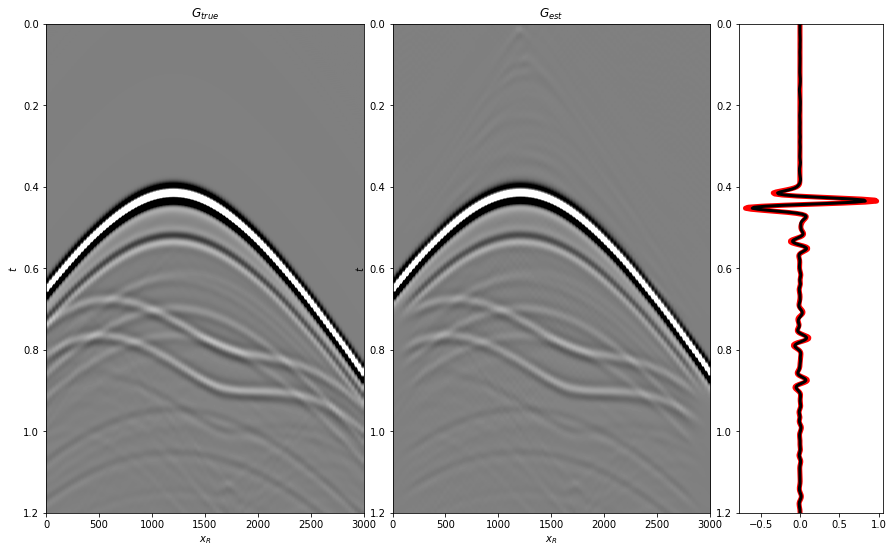

In [29]:
fig = plt.figure(figsize=(15,9))
ax1 = plt.subplot2grid((1, 5), (0, 0), colspan=2)
ax2 = plt.subplot2grid((1, 5), (0, 2), colspan=2)
ax3 = plt.subplot2grid((1, 5), (0, 4))

ax1.imshow(Gsub, cmap='gray', vmin=-5e5, vmax=5e5, extent=(r[0,0], r[0,-1], t[-1], t[0]))
ax1.set_title(r'$G_{true}$'), ax1.set_xlabel(r'$x_R$'), ax1.set_ylabel(r'$t$')
ax1.axis('tight')
ax1.set_ylim(1.2, 0)
ax2.imshow(cp.asnumpy(g_inv_tot).T, cmap='gray', vmin=-5e5, vmax=5e5, 
           extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
ax2.set_title(r'$G_{est}$'), ax2.set_xlabel(r'$x_R$'), ax2.set_ylabel(r'$t$')
ax2.axis('tight')
ax2.set_ylim(1.2, 0)

ax3.plot(Gsub[:, nr//2]/Gsub.max(), t, 'r', lw=5)
ax3.plot(cp.asnumpy(g_inv_tot)[nr//2, nt-1:]/cp.asnumpy(g_inv_tot).max(), t, 'k', lw=3)
ax3.set_ylim(1.2, 0);

## Function

In [30]:
"""
MarchenkoWM = Marchenko(Rtwosided_fft.transpose(1, 2, 0), nt=nt, dt=dt, dr=dr, 
                        nfmax=nfmax, wav=wav, toff=toff, nsmooth=nsmooth) # R[r, s, f]

f1_inv_minus_f, f1_inv_plus_f, p0_minus_f, g_inv_minus_f, g_inv_plus_f = \
  MarchenkoWM.apply_onepoint(directVS, G0=G0sub.T, rtm=True, greens=True, 
                             dottest=True, **dict(niter=n_iter, show=True))
g_inv_tot_f = g_inv_minus_f + g_inv_plus_f
"""

"""
MarchenkoWM = Marchenko(R, dt=dt, dr=dr, nfmax=nfmax, wav=wav,
                        toff=toff, nsmooth=nsmooth)

f1_inv_minus_f, f1_inv_plus_f, p0_minus_f, g_inv_minus_f, g_inv_plus_f = \
    MarchenkoWM.apply_onepoint(directVS, G0=G0sub.T, rtm=True, greens=True, 
                               dottest=False, **dict(niter=n_iter, show=True))
g_inv_tot_f = g_inv_minus_f + g_inv_plus_f
"""

MarchenkoWM = Marchenko(R, dt=dt, dr=dr, nfmax=nfmax, wav=wav,
                          toff=toff, nsmooth=nsmooth)

f1_inv_minus_f, f1_inv_plus_f, p0_minus_f, g_inv_minus_f, g_inv_plus_f = \
    MarchenkoWM.apply_onepoint(directVS, nfft=2**11, rtm=True, greens=True, 
                               dottest=False, **dict(niter=n_iter, show=True))
f1_inv_minus_f, f1_inv_plus_f, p0_minus_f, g_inv_minus_f, g_inv_plus_f = \
  1e6*f1_inv_minus_f, 1e6*f1_inv_plus_f, 1e6*p0_minus_f, 1e6*g_inv_minus_f, 1e6*g_inv_plus_f 
g_inv_tot_f = g_inv_minus_f + g_inv_plus_f

/usr/local/lib/python3.6/site-packages/pylops/waveeqprocessing/marchenko.py:231: FutureWarning: A new implementation of Marchenko is provided in v1.5.0. This currently affects only the inner working of the operator, end-users can continue using the operator in the same way. Nevertheless, R1 is not required anymoreeven when R is provided in frequency domain. It is recommended to start using the operator without the R1 input as this behaviour will become default in version v2.0.0 and R1 will be removed from the inputs.
  FutureWarning)
/usr/local/lib/python3.6/site-packages/pylops/waveeqprocessing/mdd.py:38: FutureWarning: A new implementation of MDC is provided in v1.5.0. This currently affects only the inner working of the operator, end-users can continue using the operator in the same way. Nevertheless, it is now recommended to start using the operator with transpose=True, as this behaviour will become default in version v2.0.0 and the behaviour with transpose=False will be deprecated

CGLS
-----------------------------------------------------------
The Operator Op has 322998 rows and 322998 cols
damp = 0.000000e+00	tol = 1.000000e-04	niter = 10
-----------------------------------------------------------------
    Itn           x[0]              r2norm
     1         0.0000e+00         3.3827e+02
     2         0.0000e+00         4.7437e+01
     3         0.0000e+00         2.6394e+01
     4         0.0000e+00         1.5350e+01
     5         0.0000e+00         7.6737e+00
     6         0.0000e+00         4.9865e+00
     7         0.0000e+00         3.0438e+00
     8         0.0000e+00         1.1798e+00
     9         0.0000e+00         5.9864e-01
    10         0.0000e+00         4.5082e-01

Iterations = 10        Total time (s) = 2.51
-----------------------------------------------------------------



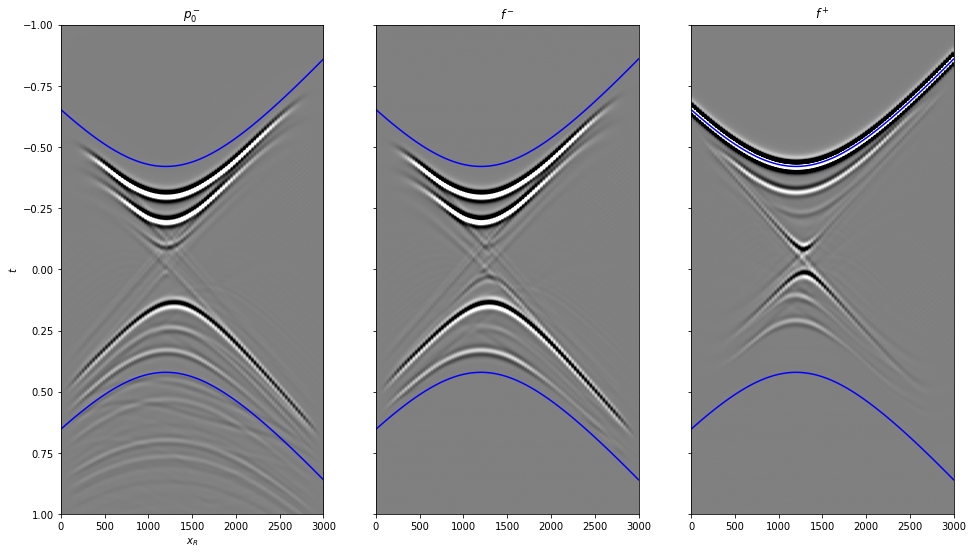

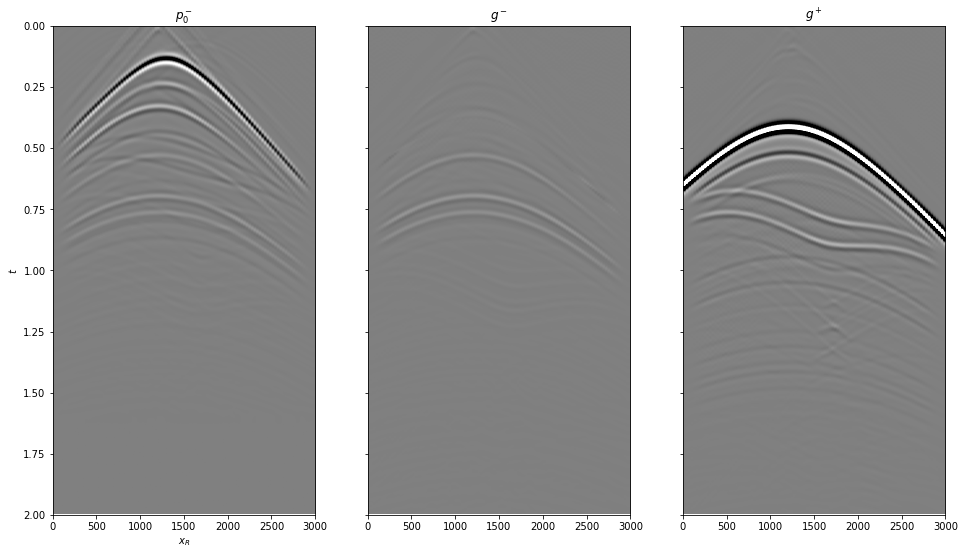

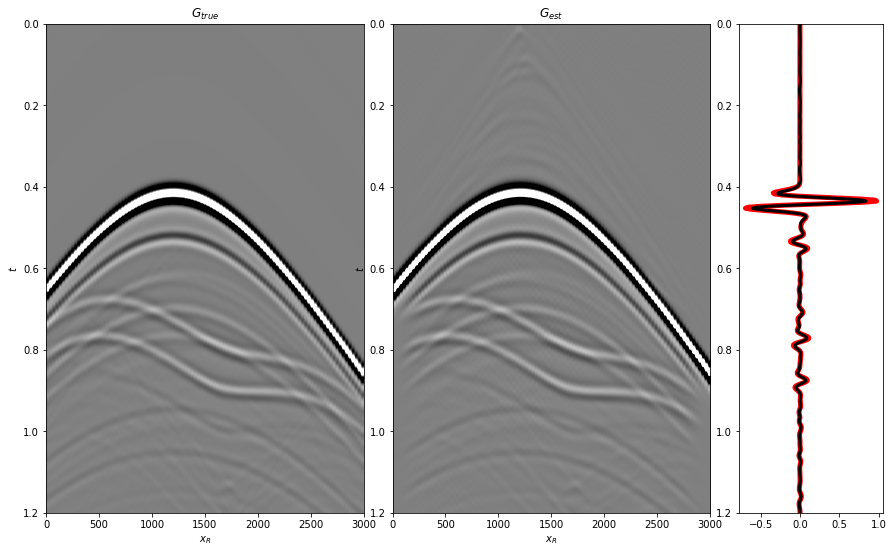

In [31]:
fig, axs = plt.subplots(1, 3, sharey=True, figsize=(16, 9))
axs[0].imshow(cp.asnumpy(p0_minus_f).T, cmap='gray', vmin=-5e5, vmax=5e5, extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
axs[0].set_title(r'$p_0^-$'), axs[0].set_xlabel(r'$x_R$'), axs[0].set_ylabel(r'$t$')
axs[0].plot(r[0], directVS,'b'),axs[0].plot(r[0], -directVS,'b')
axs[0].axis('tight')
axs[0].set_ylim(1, -1);
axs[1].imshow(cp.asnumpy(f1_inv_minus_f).T, cmap='gray', vmin=-5e5, vmax=5e5, extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
axs[1].set_title(r'$f^-$'), axs[0].set_xlabel(r'$x_R$')
axs[1].plot(r[0], directVS,'b'),axs[1].plot(r[0], -directVS,'b')
axs[1].axis('tight')
axs[1].set_ylim(1, -1);
axs[2].imshow(cp.asnumpy(f1_inv_plus_f).T, cmap='gray', vmin=-5e5, vmax=5e5, extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
axs[2].set_title(r'$f^+$'), axs[0].set_xlabel(r'$x_R$')
axs[2].plot(r[0], directVS,'b'),axs[2].plot(r[0], -directVS,'b')
axs[2].axis('tight')
axs[2].set_ylim(1, -1);

fig, axs = plt.subplots(1, 3, sharey=True, figsize=(16, 9))
axs[0].imshow(cp.asnumpy(p0_minus_f).T, cmap='gray', vmin=-5e5, vmax=5e5, extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
axs[0].set_title(r'$p_0^-$'), axs[0].set_xlabel(r'$x_R$'), axs[0].set_ylabel(r'$t$')
axs[0].axis('tight')
axs[0].set_ylim(2, 0);
axs[1].imshow(cp.asnumpy(g_inv_minus_f).T, cmap='gray', vmin=-5e5, vmax=5e5, extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
axs[1].set_title(r'$g^-$'), axs[0].set_xlabel(r'$x_R$')
axs[1].axis('tight')
axs[1].set_ylim(2, 0);
axs[2].imshow(cp.asnumpy(g_inv_plus_f).T, cmap='gray', vmin=-5e5, vmax=5e5, extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
axs[2].set_title(r'$g^+$'), axs[0].set_xlabel(r'$x_R$')
axs[2].axis('tight')
axs[2].set_ylim(2, 0);

fig = plt.figure(figsize=(15,9))
ax1 = plt.subplot2grid((1, 5), (0, 0), colspan=2)
ax2 = plt.subplot2grid((1, 5), (0, 2), colspan=2)
ax3 = plt.subplot2grid((1, 5), (0, 4))

ax1.imshow(Gsub, cmap='gray', vmin=-5e5, vmax=5e5, extent=(r[0,0], r[0,-1], t[-1], t[0]))
ax1.set_title(r'$G_{true}$'), ax1.set_xlabel(r'$x_R$'), ax1.set_ylabel(r'$t$')
ax1.axis('tight')
ax1.set_ylim(1.2, 0)
ax2.imshow(cp.asnumpy(g_inv_tot_f).T, cmap='gray', vmin=-5e5, vmax=5e5, 
              extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
ax2.set_title(r'$G_{est}$'), ax2.set_xlabel(r'$x_R$'), ax2.set_ylabel(r'$t$')
ax2.axis('tight')
ax2.set_ylim(1.2, 0)

ax3.plot(Gsub[:, nr//2]/Gsub.max(), t, 'r', lw=5)
ax3.plot(cp.asnumpy(g_inv_tot_f)[nr//2, nt-1:]/cp.asnumpy(g_inv_tot_f).max(), t, 'k', lw=3)
ax3.set_ylim(1.2, 0);

## Multiple points

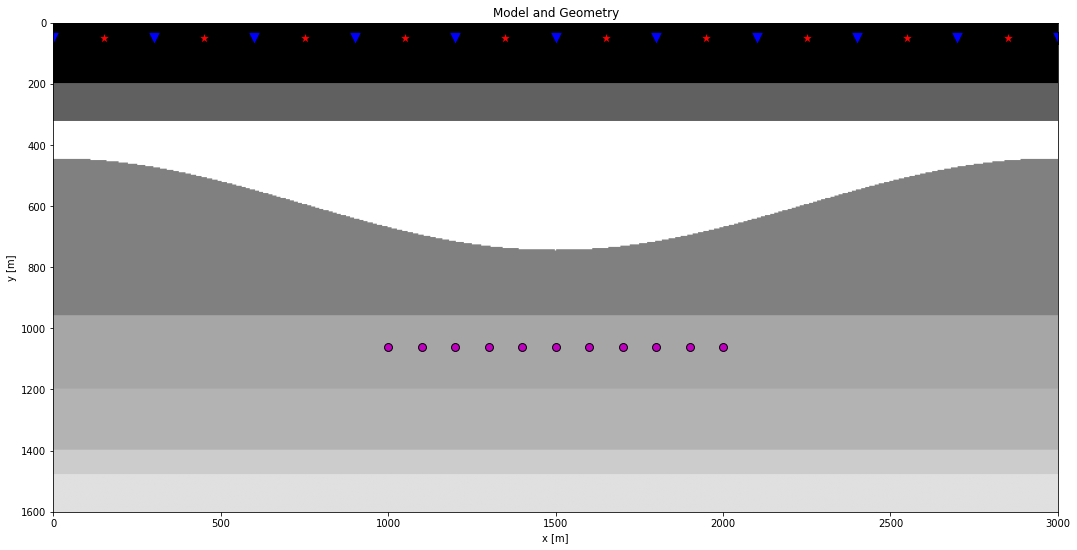

In [32]:
nvs = 11
vs = [np.arange(11)*100 + 1000, 
      np.ones(11)*1060]

plt.figure(figsize=(18,9))
plt.imshow(rho, cmap='gray', extent = (x[0], x[-1], z[-1], z[0]))
plt.scatter(s[0, 5::10], s[1, 5::10], marker='*', s=150, c='r', edgecolors='k')
plt.scatter(r[0, ::10],  r[1, ::10], marker='v', s=150, c='b', edgecolors='k')
plt.scatter(vs[0], vs[1], marker='.', s=250, c='m', edgecolors='k')
plt.axis('tight')
plt.xlabel('x [m]'),plt.ylabel('y [m]'),plt.title('Model and Geometry')
plt.xlim(x[0], x[-1]);

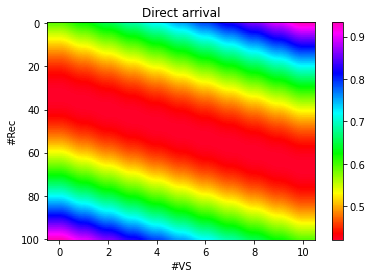

In [33]:
# direct arrival window - traveltime
directVS = np.sqrt((vs[0]-r[0][:, np.newaxis])**2+(vs[1]-r[1][:, np.newaxis])**2)/vel
directVS_off = directVS - toff

plt.figure()
im = plt.imshow(directVS, cmap='gist_rainbow')
plt.axis('tight')
plt.xlabel('#VS'),plt.ylabel('#Rec'),plt.title('Direct arrival')
plt.colorbar(im);

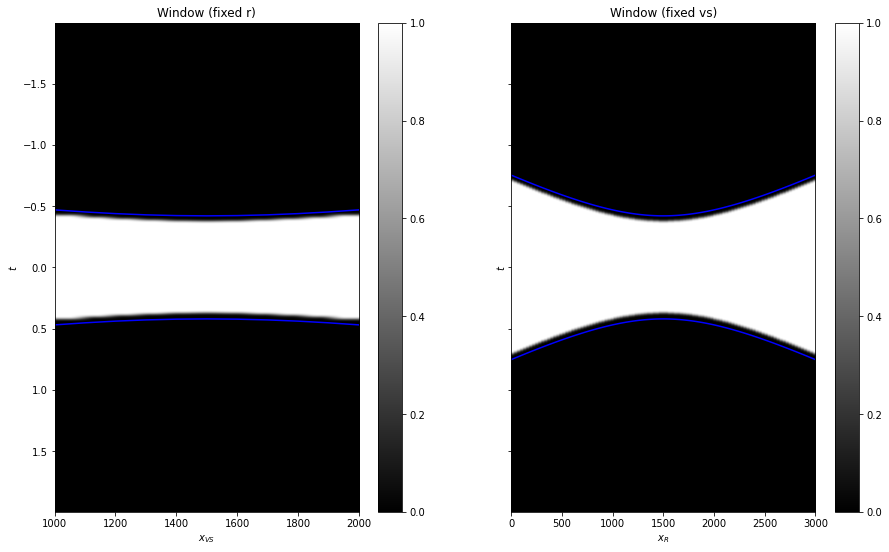

In [34]:
idirectVS_off = np.round(directVS_off/dt).astype(np.int)
w = np.zeros((nr, nvs, nt))
for ir in range(nr):
    for ivs in range(nvs):
        w[ir, ivs, :idirectVS_off[ir, ivs]]=1            
w = np.concatenate((np.flip(w, axis=-1), w[:,:, 1:]), axis=-1)

if nsmooth>0:
    smooth=np.ones(nsmooth)/nsmooth
    w  = filtfilt(smooth, 1, w)    

fig, axs = plt.subplots(1, 2,  sharey=True, figsize=(15, 9))
im = axs[0].imshow(w[nr//2].T, cmap='gray', extent=(vs[0][0], vs[0][-1], t[-1], -t[-1]))
axs[0].plot(vs[0], directVS[nr//2],'b'),axs[0].plot(vs[0], -directVS[nr//2],'b')
axs[0].set_title('Window (fixed r)'), axs[0].set_xlabel(r'$x_{VS}$'), axs[0].set_ylabel(r'$t$')
axs[0].axis('tight')
fig.colorbar(im, ax=axs[0])
im = axs[1].imshow(w[:, nvs//2].T, cmap='gray', 
                   extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
axs[1].plot(r[0], directVS[:, nvs//2],'b'),axs[1].plot(r[0], -directVS[:, nvs//2],'b')
axs[1].set_title('Window (fixed vs)'), axs[1].set_xlabel(r'$x_R$'), axs[1].set_ylabel(r'$t$')
axs[1].axis('tight')
fig.colorbar(im, ax=axs[1]);

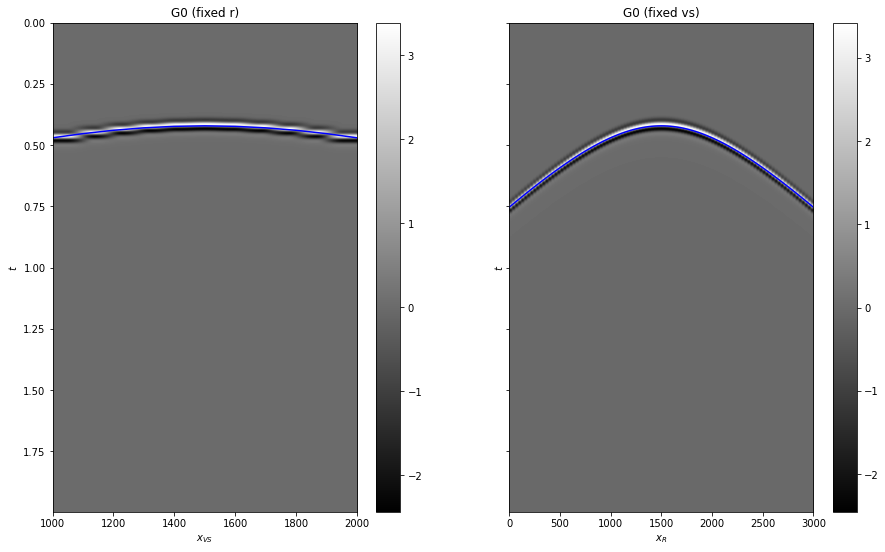

In [35]:
G0sub_ana = np.zeros((nr, nvs, nt))
for ivs in range(nvs):
    G0sub_ana[:, ivs] = directwave(wav, directVS[:,ivs], nt, dt, nfft=int(2**(np.ceil(np.log2(nt))))).T

fig, axs = plt.subplots(1, 2,  sharey=True, figsize=(15, 9))
im = axs[0].imshow(G0sub_ana[nr//2].T, cmap='gray', extent=(vs[0][0], vs[0][-1], t[-1], t[0]))
axs[0].plot(vs[0], directVS[nr//2],'b')
axs[0].set_title('G0 (fixed r)'), axs[0].set_xlabel(r'$x_{VS}$'), axs[0].set_ylabel(r'$t$')
axs[0].axis('tight')
fig.colorbar(im, ax=axs[0])
im = axs[1].imshow(G0sub_ana[:,nvs//2].T, cmap='gray', extent=(r[0,0], r[0,-1], t[-1], t[0]))
axs[1].plot(r[0], directVS[:, nvs//2],'b')
axs[1].set_title('G0 (fixed vs)'), axs[1].set_xlabel(r'$x_R$'), axs[1].set_ylabel(r'$t$')
axs[1].axis('tight')
fig.colorbar(im, ax=axs[1]);

In [36]:
MarchenkoWM = Marchenko(R, dt=dt, dr=dr, nfmax=nfmax, wav=wav,
                        toff=toff, nsmooth=nsmooth)

f1_inv_minus_f, f1_inv_plus_f, p0_minus_f, g_inv_minus_f, g_inv_plus_f = \
    MarchenkoWM.apply_multiplepoints(directVS, nfft=2**11, rtm=True, greens=True, 
                                     dottest=False, **dict(niter=n_iter, show=True))
g_inv_tot_f = g_inv_minus_f + g_inv_plus_f

/usr/local/lib/python3.6/site-packages/pylops/waveeqprocessing/marchenko.py:231: FutureWarning: A new implementation of Marchenko is provided in v1.5.0. This currently affects only the inner working of the operator, end-users can continue using the operator in the same way. Nevertheless, R1 is not required anymoreeven when R is provided in frequency domain. It is recommended to start using the operator without the R1 input as this behaviour will become default in version v2.0.0 and R1 will be removed from the inputs.
  FutureWarning)
/usr/local/lib/python3.6/site-packages/pylops/waveeqprocessing/mdd.py:38: FutureWarning: A new implementation of MDC is provided in v1.5.0. This currently affects only the inner working of the operator, end-users can continue using the operator in the same way. Nevertheless, it is now recommended to start using the operator with transpose=True, as this behaviour will become default in version v2.0.0 and the behaviour with transpose=False will be deprecated

CGLS
-----------------------------------------------------------
The Operator Op has 3552978 rows and 3552978 cols
damp = 0.000000e+00	tol = 1.000000e-04	niter = 10
-----------------------------------------------------------------
    Itn           x[0]              r2norm
     1         0.0000e+00         3.6955e+03
     2         0.0000e+00         5.1828e+02
     3         0.0000e+00         2.7710e+02
     4         0.0000e+00         1.6801e+02
     5         0.0000e+00         8.5719e+01
     6         0.0000e+00         5.3023e+01
     7         0.0000e+00         3.5349e+01
     8         0.0000e+00         1.5271e+01
     9         0.0000e+00         7.4750e+00
    10         0.0000e+00         6.0242e+00

Iterations = 10        Total time (s) = 1.03
-----------------------------------------------------------------



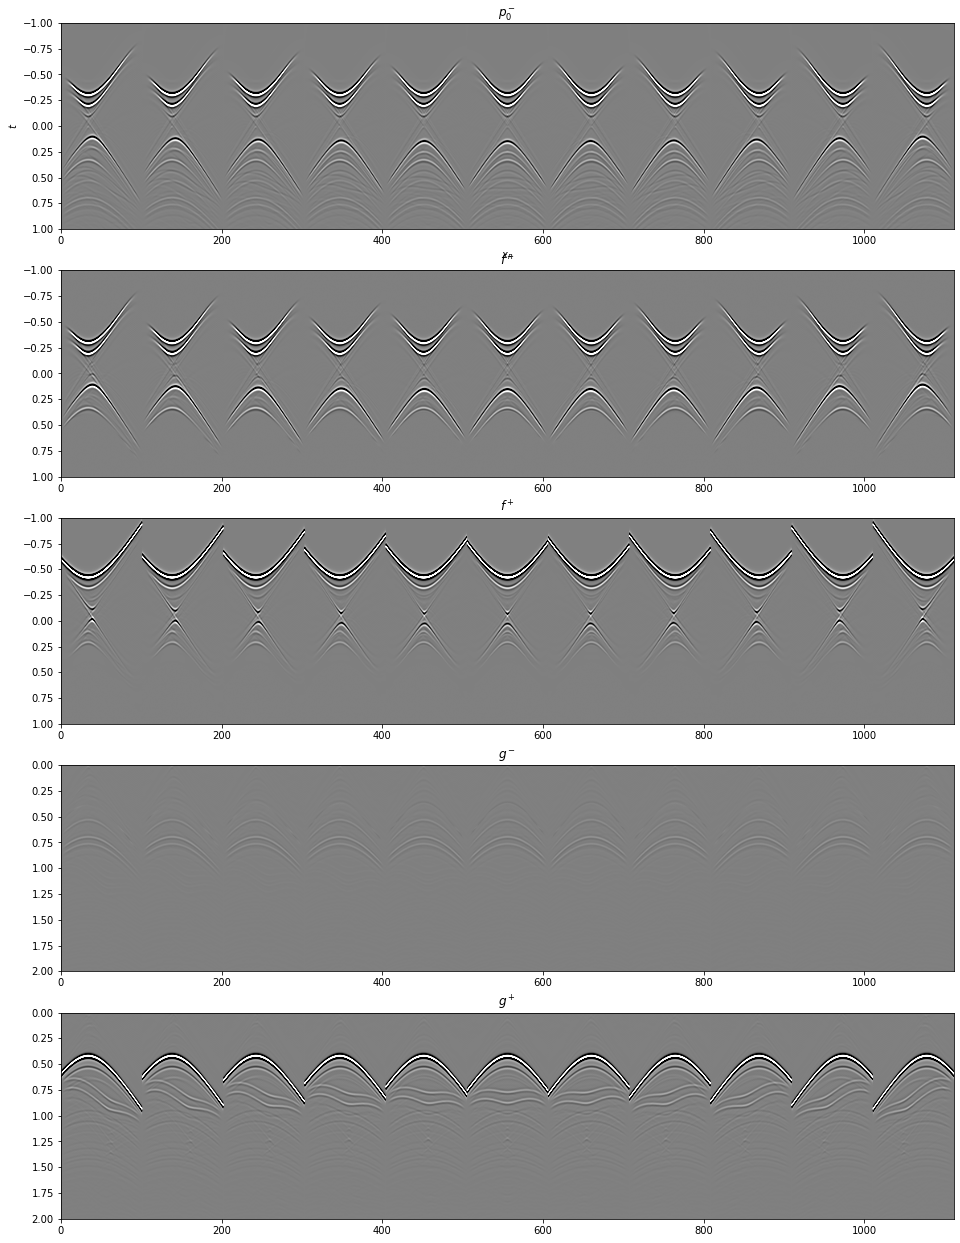

In [37]:
fig, axs = plt.subplots(5, 1, figsize=(16, 22))
axs[0].imshow(cp.asnumpy(np.swapaxes(p0_minus_f, 0, 1).reshape(nr*nvs, 2*nt-1).T), cmap='gray', 
              vmin=-5e-1, vmax=5e-1, extent=(0, nr*nvs, t[-1], -t[-1]))
axs[0].set_title(r'$p_0^-$'), axs[0].set_xlabel(r'$x_R$'), axs[0].set_ylabel(r'$t$')
axs[0].axis('tight')
axs[0].set_ylim(1, -1);
axs[1].imshow(cp.asnumpy(np.swapaxes(f1_inv_minus_f, 0, 1).reshape(nr*nvs,2*nt-1).T), cmap='gray', 
              vmin=-5e-1, vmax=5e-1, extent=(0, nr*nvs, t[-1], -t[-1]))
axs[1].set_title(r'$f^-$'), axs[0].set_xlabel(r'$x_R$')
axs[1].axis('tight')
axs[1].set_ylim(1, -1);
axs[2].imshow(cp.asnumpy(np.swapaxes(f1_inv_plus_f, 0, 1).reshape(nr*nvs,2*nt-1).T), cmap='gray', 
              vmin=-5e-1, vmax=5e-1, extent=(0, nr*nvs, t[-1], -t[-1]))
axs[2].set_title(r'$f^+$'), axs[0].set_xlabel(r'$x_R$')
axs[2].axis('tight')
axs[2].set_ylim(1, -1);
axs[3].imshow(cp.asnumpy(np.swapaxes(g_inv_minus_f, 0, 1).reshape(nr*nvs,2*nt-1).T), cmap='gray', 
              vmin=-5e-1, vmax=5e-1, extent=(0, nr*nvs, t[-1], -t[-1]))
axs[3].set_title(r'$g^-$'), axs[0].set_xlabel(r'$x_R$')
axs[3].axis('tight')
axs[3].set_ylim(2, 0);
axs[4].imshow(cp.asnumpy(np.swapaxes(g_inv_plus_f, 0, 1).reshape(nr*nvs,2*nt-1).T), cmap='gray', 
              vmin=-5e-1, vmax=5e-1, extent=(0, nr*nvs, t[-1], -t[-1]))
axs[4].set_title(r'$g^+$'), axs[0].set_xlabel(r'$x_R$')
axs[4].axis('tight')
axs[4].set_ylim(2, 0);

In [38]:
MarchenkoWMnp = Marchenko(cp.asnumpy(R), dt=dt, dr=dr, nfmax=nfmax, wav=cp.asnumpy(wav),
                        toff=toff, nsmooth=nsmooth)

%timeit -n1 -r1 MarchenkoWMnp.apply_multiplepoints(directVS, nfft=2**11, rtm=True, greens=True, dottest=False, **dict(iter_lim=n_iter, show=False));
%timeit -n1 -r1 MarchenkoWM.apply_multiplepoints(directVS, nfft=2**11, rtm=True, greens=True, dottest=False, **dict(niter=n_iter, show=False));

/usr/local/lib/python3.6/site-packages/pylops/waveeqprocessing/marchenko.py:231: FutureWarning: A new implementation of Marchenko is provided in v1.5.0. This currently affects only the inner working of the operator, end-users can continue using the operator in the same way. Nevertheless, R1 is not required anymoreeven when R is provided in frequency domain. It is recommended to start using the operator without the R1 input as this behaviour will become default in version v2.0.0 and R1 will be removed from the inputs.
  FutureWarning)
/usr/local/lib/python3.6/site-packages/pylops/waveeqprocessing/mdd.py:38: FutureWarning: A new implementation of MDC is provided in v1.5.0. This currently affects only the inner working of the operator, end-users can continue using the operator in the same way. Nevertheless, it is now recommended to start using the operator with transpose=True, as this behaviour will become default in version v2.0.0 and the behaviour with transpose=False will be deprecated

1 loop, best of 1: 15.9 s per loop


/usr/local/lib/python3.6/site-packages/pylops/waveeqprocessing/mdd.py:38: FutureWarning: A new implementation of MDC is provided in v1.5.0. This currently affects only the inner working of the operator, end-users can continue using the operator in the same way. Nevertheless, it is now recommended to start using the operator with transpose=True, as this behaviour will become default in version v2.0.0 and the behaviour with transpose=False will be deprecated.
  'transpose=False will be deprecated.', FutureWarning)


1 loop, best of 1: 1.85 s per loop
